# [LEGALST-123] Lab 25: Decision Trees and Ensemble Methods
---
<img src="https://c.pxhere.com/photos/df/5e/uganda_signs_outdoor_wooden_sign_direction_this_wy_that_way-341892.jpg!d" style="width: 600px; height: 400px;" />


This will wrap up the regression methods labs by introducing ensemble methods.

*Estimated Time: 40 minutes*

---

### Table of Contents


1 - [Base Model: Decision Trees](#section 1)<br>

2 - [Averaging Methods](#section 2)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 - [Random Forest](#subsection 1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 - [Grid Search](#subsection 2)

3 - [Boosting Methods](#section 3)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 - [Ada Boost](#subsection 1)

4 - [Feedback Survey](#section 4)<br>

---

**Dependencies:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import ipywidgets as widgets

## The Data: Bike Sharing<a id='section data'></a>

Today's lab will use the now-familiar bike-sharing data set. Run the cell below to load the data.

Information about the dataset: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [2]:
bike = pd.read_csv('data/day.csv', index_col=0)
# reformat the date column to integers that represent the day of the year, 001-366
bike['dteday'] = pd.to_datetime(bike['dteday'].unique()).strftime('%j')

bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
3,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
4,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
5,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Introduction
Over the course of this class, we've seen that a single model may have significant trouble making accurate predictions. **Ensemble methods** seek to improve on the single-model method by combining the predictions from multiple base models.

This lab will cover the two types of ensemble methods- averaging and boosting- using decision trees as our base model. But, one of the strengths of ensemble methods is their ability to solve many kinds of problems using many different kinds of base models.

As always, we start by dividing our data into training, validation, and test data. 

In [3]:
# divide data into features and values to predict
X= bike.drop(['cnt', 'casual', 'registered'], axis=1)
y= bike.cnt

# set the random seed
np.random.seed(10)

# split the data with 0.20 proportion for test size
# train_test_split returns 4 values: X_train, X_test, y_train, y_test 
X, X_test, y, y_test = train_test_split(X, y,
                                            train_size=0.80, test_size=0.20)
# split the remaining data with 0.75 proportion for train size and 0.25 for validation size
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

---
## 1. The Base Model: Decision Tree <a id='section 1'></a>

In the previous lab, you used an **ExtraTree** (EXTremely RAndomized TREE) to identify low-importance features. Extra trees are a subclass of a model called the **Decision Tree**, which we'll explore in more detail today.

Decision trees predict target values by creating a set of decision rules. The tree is made up of *nodes*, which constitute decision points, and *branches*, which represent the outcome of the decision. Here's an example using the [Titanic](https://www.kaggle.com/c/titanic/data) data set to predict whether or not a passenger survived the sinking of the ship. Nodes are represented by the text, and branches by lines (left branch = 'yes', right branch='no').

Starting at the *root node* (which in computer science, somewhat counterintuitively, is at the top), the data is split into different subgroups at each decision node going top to bottom. The very bottom nodes in the tree (the *leaves*) assign prediction values to the data. 

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png" style="width: 400px; height: 400px;" />

> *'sibsp' gives the number of siblings or spouses a passanger had on board. The left number under a leaf is the chance of survival for that subgroup; the right number is the percentage of passengers in that subgroup. *


**QUESTION:** Based on this decision tree, what would the model predict would happen to an 8-year-old boy with 2 sisters and a brother? What would the chance of survival be for a 28-year-old married man?

**ANSWER:** The boy would be predicted to survive. The man would have survived with a 17% chance.

While the Titanic data uses decision trees for categorization, they can also be used for regression. The process is very similar to the other Scikit-Learn models you've used.
1. Create the `DecisionTreeRegressor()`. Set `max_depth` equal to 3.
2. Fit `X_train` and `y_train` to the regressor to create the model


Note: The `max_depth=` parameter of DecisionTreeRegression constrains how many times a data set can be split. For example, the Titanic tree had a max depth of 3 (i.e. you could pass through at most 3 branches when going from the root to a leaf). 

In [4]:
# make the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(criterion='mse',  # how to measure fit
                               splitter='best',  # or 'random' for random best split
                               max_depth=3,  # how deep tree nodes can go
                               min_samples_split=2,  # samples needed to split node
                               min_samples_leaf=1,  # samples needed for a leaf
                               min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                               max_features=None,  # number of features to look for when splitting
                               max_leaf_nodes=None,  # max nodes
                               min_impurity_decrease=1e-07)  # early stopping

# fit the model
model = dt_reg.fit(X_train, y_train)

# score the model
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.7751431247240366
0.7483879642239408


The `feature_importances_` show how much weight is given to each feature in the model. Higher numbers correspond to more important features. The importances correspond to features by their index: the importance weight in position 1 goes with feature 1, and so on.

In [5]:
# show the feature importance, in a data frame for convenience
pd.DataFrame({'feature': X.columns,
             'importance': model.feature_importances_})

,feature,importance
0,dteday,0.000000
1,season,0.000000
2,yr,0.421531
3,mnth,0.019294
4,holiday,0.000000
5,weekday,0.000000
6,workingday,0.000000
7,weathersit,0.000000
8,temp,0.079241
9,atemp,0.479934


Now, complete the final steps:
3. Check the model's accuracy on the training and validation data using `.score`
4. Plot the predictions of the model against the actual values in a scatter plot

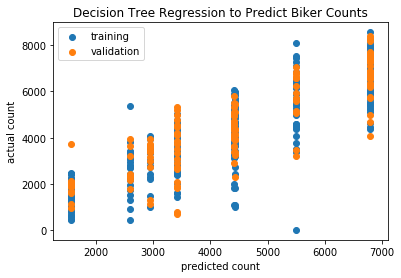

In [6]:
# predict values for the training and validation sets
pred_y_val = model.predict(X_val)
pred_y_train = model.predict(X_train)

# plot the predicted values against the true values
plt.scatter(pred_y_train, y_train, label='training')
plt.scatter(pred_y_val, y_val, label='validation')
plt.xlabel('predicted count')
plt.ylabel('actual count')
plt.legend()
plt.title('Decision Tree Regression to Predict Biker Counts');

**QUESTION:** The scatter plot looks kind of funky. Based on what you know about how decision trees make predictions, why would that be the case? 

Hint: look at the one parameter we changed from its default value

**ANSWER:** 

For a max depth of $n$, there are at most $2^n$ possible predicted values, since that's the maximum number of branch splits.  Since we set the max depth to be 3, there are at most $2^3=8$ possible values that the tree can predict.

### Visualization


One of the great thing about decision trees is that, unlike many other models, it's relatively easy to visualize what is going on inside the model. The graphviz library can show the structure of the tree, as well as what decision is being made at each node.

Due to some datahub limitations we can't use graphviz directly through our notebook. However, we can use the [Webgraphviz site](http://webgraphviz.com/) as a workaround. Run the cell below to generate the graphviz data for the model you just trained. Then, copy the *entire* output of the cell, click the link to Webgraphviz, replace the sample text in the text box with your copied data, and hit the button to generate the graph.

In [7]:
# get the graphviz data
print(export_graphviz(model, out_file = None, feature_names = X.columns))

digraph Tree {
node [shape=box] ;
0 [label="atemp <= 0.387\nmse = 3786289.348\nsamples = 438\nvalue = 4434.447"] ;
1 [label="yr <= 0.5\nmse = 2280497.779\nsamples = 148\nvalue = 2816.757"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="mnth <= 10.5\nmse = 670959.959\nsamples = 77\nvalue = 1876.169"] ;
1 -> 2 ;
3 [label="mse = 257801.196\nsamples = 60\nvalue = 1574.067"] ;
2 -> 3 ;
4 [label="mse = 670179.066\nsamples = 17\nvalue = 2942.412"] ;
2 -> 4 ;
5 [label="temp <= 0.28\nmse = 2026031.943\nsamples = 71\nvalue = 3836.831"] ;
1 -> 5 ;
6 [label="mse = 1086082.386\nsamples = 23\nvalue = 2598.304"] ;
5 -> 6 ;
7 [label="mse = 1389211.998\nsamples = 48\nvalue = 4430.292"] ;
5 -> 7 ;
8 [label="yr <= 0.5\nmse = 2537646.516\nsamples = 290\nvalue = 5260.028"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="atemp <= 0.522\nmse = 869684.409\nsamples = 144\nvalue = 4077.646"] ;
8 -> 9 ;
10 [label="mse = 823007.385\nsamples = 48\nvalue = 3411

Some notes on the visualization:
- the top line of every node shows the decision that splits the data at that node
- `samples` is the number of samples (rows) that are going through that node on the way down the tree
- `value` is the value that would be predicted for all samples that stop at that node
- `mse` is the mean squared error that would result from all of that node's samples being given `value` as their prediction

## 2. Averaging Methods <a id='section 2'></a>

We have seen that the decision tree quickly maxed out its training set accuracy, but that accuracy didn't necessarily carry over to the validation set. We can try to address this overfitting issue using **averaging** ensemble methods. The intuition behind averaging is to build multiple estimators, then use the average of all their predictions as the final prediction.

### Random Forest

**Random Forest** accomplishes this by creating multiple decision trees (a 'forest' of them, if you will), each trained on sample of data drawn at random with replacement from the given set. Additionally, when each tree is constructed, not every feature is considered as a candidate on which to split the tree for each decision point.

By adding some randomization into the subsets and features that are considered by each model, then averaging the predictions across models, Random Forest can typically produce a model that is better at generalization.

**EXERCISE:** Create an out-of-the-box `RandomForestRegessor()` (i.e. use all the default settings), then fit it to the data and get the model's scores on the training and validation data. How does it compare to the Decision Tree?

In [8]:
# create the regressor
rf_reg = RandomForestRegressor(n_estimators=10,  # number of trees
                               criterion='mse',  # how to measure fit
                               max_depth=None,  # how deep tree nodes can go
                               min_samples_split=2,  # samples needed to split node
                               min_samples_leaf=1,  # samples needed for a leaf
                               min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                               max_features='auto',  # max feats
                               max_leaf_nodes=None,  # max nodes
                               n_jobs=1, # how many to run parallel
                               random_state=10)
# fit the data 
model = rf_reg.fit(X_train, y_train)

#score the model on the training and validation data
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.9669808335267238
0.9042413756654382


Like with most models, we can get better results by tuning the hyperparameters of the model. Let's try changing three: `max_depth`, `n_estimators`, and `min_samples_split`.

The code in the cell below allows you to compare the scatter plots and scores for different values of these parameters by changing the values in the different sliders. 

In [9]:
def scatter_by_param(depth, estimators, min_samples_split):
    """Train a DecisionTreeRegressor with max_depth=DEPTH, n_estimators=ESTIMATORS,
    min_samples_split=MIN_SAMPLES_SPLIT and plot the scatter plot of predicted values 
    for training and validation data."""
    
    # make and train the model
    dt_reg = RandomForestRegressor(max_depth = depth, n_estimators=estimators, 
                                   min_samples_split = min_samples_split)
    model = dt_reg.fit(X_train, y_train)
    
    # predict values for training and validation sets
    pred_y_val = model.predict(X_val)
    pred_y_train = model.predict(X_train)
    
    # plot predicted against actual values for training and validation sets
    plt.scatter(pred_y_train, y_train, label='training')
    plt.scatter(pred_y_val, y_val, label='validation')
    plt.xlabel('predicted count')
    plt.ylabel('actual count')
    plt.title('Random Forest Regression')
    
    # get scores for training and validation sets
    print('training score: ', model.score(X_train, y_train))
    print('validation score: ', model.score(X_val, y_val))

# create the slider sfor the widget
slider = widgets.IntSlider(min=1, max=21,step=1,value=0)
slider2 = widgets.IntSlider(min=1, max=10,step=1,value=0)
slider3 = widgets.IntSlider(min=2, max=50,step=5,value=0)

# create the widget to view plots for different parameter values
display(widgets.interactive(scatter_by_param, depth=slider, estimators=slider2, min_samples_split=slider3))

interactive(children=(IntSlider(value=1, description='depth', max=21, min=1), IntSlider(value=1, description='…

**QUESTION:** How does each parameter change the accuracy of predictions? Do any parameters affect training accuracy differently from validation accuracy?

**ANSWER:**

### Grid Search

The process of choosing good hyperparameters can be tedious, involving a lot of trial and error. Fortunately, Scikit-Learn has a tool to help.

A **grid search** tests different possible parameter combinations to see which combination yields the best results. The grid is formatted as a dictionary, where the keys are the parameter names and the values are the different values you want to try for each parameter.

In [10]:
# create a parameter grid to look for optimal values for n_estimators, max_depth, and _min_samples_split
param_grid = {'n_estimators': range(450, 551, 50),
              'max_depth': range(1, 12, 5),
              'min_samples_split': [2]}



Once the grid is made, it gets fed into a `GridSearchCV` along with the corresponding model. This may take several seconds to run- the computer is calculating the score for every possible combination of parameter values in the grid.

In [11]:
grid_search = GridSearchCV(RandomForestRegressor(), param_grid)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

Once we've fit the model to the data, information about the search process and results is stored in `.cv_results_`. Here's what you can see:

In [12]:
# the keys stored in the grid search process results dictionary
sorted(grid_search.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_min_samples_split',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

"params" contains the different combinations of parameters that were tried. "mean_test_score" gives the average score for models using each set of parameters. Items are matched by index- the ith score is for the ith set of parameters.

In [13]:
grid_search.cv_results_["params"]

[{'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 450},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 500},
 {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 550},
 {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 450},
 {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 500},
 {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 550},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 450},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 500},
 {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 550}]

In [14]:
grid_search.cv_results_["mean_test_score"]

array([0.46368733, 0.47104456, 0.46166105, 0.84880539, 0.84791325,
       0.84877582, 0.86024697, 0.8603762 , 0.86309736])

**EXERCISE:** Find the set of parameters that got the best average score (`np.argmax` might help). Create a new random forest regressor using those parameters, then fit the model and print the scores for the training and validation data.

In [15]:
best_index = np.argmax(grid_search.cv_results_["mean_test_score"])
best_params = grid_search.cv_results_["params"][best_index]

# create the regressor
rf_reg2 = RandomForestRegressor(n_estimators=450,  # number of trees
                                max_depth=11,  # how deep tree nodes can go
                                min_samples_split=2)
# fit the data 
model = rf_reg2.fit(X_train, y_train)

#score the model on the training and validation data
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.9805447735938987
0.9215246670146159


And, as always, there is a shortcut- if you call `.predict` or `.score` on the grid search object you originally used to find the best parameters, it will do so using the best set of parameters automatically. Note that the score might be slightly different from the one in the model you just calculated due to the 'random' part of 'random forest'.

In [16]:
grid_search.score(X_val, y_val)

0.9213662884878631

## 3. Boosting Methods <a id='section 3'></a>

**Boosting** algorithms work roughly like so:
1. Make a weak predictor (one that makes predictions with slightly better-than-chance accuracy)
2. Train and evaluate the weak predictor
3. Make a new weak predictor that takes into account the errors made in the last model and improves on them.
4. Repeat steps 2 and 3 many times

### Ada Boost

Ada Boost (for ADAptive BOOSTing) is one of the most popular boosting algorithms. The adaptive part of the algorithm comes from how it updates the data for each weak model in the sequence.

Each sample $i$ in the training set is weighted by some number $w_i$, and the input to the model is the samples multiplied by the weights. At first, all the $w_i$s are the same. After the first model is evaluated, the weights are updated so that samples that were predicted incorrectly get higher weights and samples that were predicted correctly get lower weights.

**QUESTION:** In the playground game "Duck, Duck, Goose", children are labeled as 'ducks' or 'geese' in the name of schoolyard mayhem. Suppose we want to build a classifier that predicts whether a sample is a duck or a goose based on two features: color, and whether or not it quacks.

In [17]:
birds = pd.DataFrame({'color':['white', 'grey', 'white'],
                      'quacks':['yes', 'yes', 'no'],
                     'type':['duck', 'duck', 'goose']})
birds

,color,quacks,type
0,white,yes,duck
1,grey,yes,duck
2,white,no,goose


Initially, all the weights are the same.

In [18]:
birds['weights'] = np.ones(3) / 3
birds

,color,quacks,type,weights
0,white,yes,duck,0.333333
1,grey,yes,duck,0.333333
2,white,no,goose,0.333333


The initial model in a sequence for Ada Boost outputs the following predictions:

In [19]:
birds['predictions'] = ['duck', 'goose', 'goose']
birds

,color,quacks,type,weights,predictions
0,white,yes,duck,0.333333,duck
1,grey,yes,duck,0.333333,goose
2,white,no,goose,0.333333,goose


For samples 0, 1 and 2, state whether their corresponding weight would be adjusted higher, lower, or stay the same before the data is fed into the next model.

**ANSWER:**
- Sample 0: lower
- Sample 1: higher
- Sample 2: lower

Using an Ada Boost Regressor is nearly identical to using the other regressors covered today.

In [20]:
# initialize the regressor
ada_reg = AdaBoostRegressor(base_estimator=None,  # default is decision tree 
                            n_estimators=50,  # number of trees to try before stopping
                            learning_rate=1.0,  # decrease influence of each additional estimator
                            random_state=10, # sets the random seed
                            loss='linear')  # also ‘square’, ‘exponential’

# fit the data
ada_model = ada_reg.fit(X_train, y_train)

# score the model
print(ada_model.score(X_train, y_train))
print(ada_model.score(X_val, y_val))

0.8700483445300711
0.8651903257598148


**EXERCISE:** Use grid search to find better values for the Ada Boost parameters. Refer to section 2 as needed for code examples.
1. Create the parameter grid. Use any Ada Boost parameters you'd like (check the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) for more details).
2. Use scikit-learn tools to do the grid seach
3. Print the scores for the validation data using the trained, optimized model

In [21]:
# create the dictionary with parameter names and values to try
param_grid = {'n_estimators': range(50, 451, 50),
              'learning_rate': np.arange(0.01, .22, .1),
              'loss': ['square', 'exponential', 'linear']}

In [22]:
# initialize the grid search
grid_search_ab = GridSearchCV(AdaBoostRegressor(), param_grid)

# fit the data
grid_search_ab.fit(X_train, y_train)

# score the data
grid_search_ab.score(X_val, y_val)

0.8683592836540136

In summary:
- decision trees make predictions using 'if/then/else' rules to split data into subsets, but are highly subject to overfitting
- grid search can be a useful tool for tuning hyperparameters
- ensemble methods seek to improve models by averaging or boosting multiple models
- random forest uses randomness and averaging to counter the overfitting problem for decision trees
- Ada boost can be used on a variety of model types to taking an initial weak model and improve it with sequential boosting

---

## Before you go! (Feedback survey) <a id='section 4'></a>

We on the LEGALST 123 Data Science Modules team have had a blast making your notebooks this semester- now, we'd like your feedback on how we did! Please fill out [this short (<5 minutes) survey](https://docs.google.com/forms/d/e/1FAIpQLSf2FSqRHCU7mKfAMho4Easi9DnRGAXuRYXviFTTGbvW-2SRTQ/viewform) about the Jupyter notebooks you've used in  your labs this semester. Did you want more graphing? Less math? Let us know!

Thanks, and best of luck with all your future data science explorations!

---

## Bibliography

- Random Forest, ADA Boost, grid search code adapted from https://github.com/dlab-berkeley/python-machine-learning/blob/master
- Ensemble methods general reference: http://scikit-learn.org/stable/modules/ensemble.html

---
Notebook developed by: Keeley Takimoto

Data Science Modules: http://data.berkeley.edu/education/modules
